# QUELS USAGES DU SERVICE DES RÉSERVATIONS ?

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from kiblib.utils import lucas_sns_params
from kiblib.utils.db import DbConn
import warnings
warnings.filterwarnings("ignore")

In [2]:
maj = dt.today().strftime('%d-%m-%Y à %Hh%M' )
print(f"Dernière mise à jour le {maj}")

Dernière mise à jour le 05-12-2023 à 12h14


In [3]:
query = f"""SELECT borrowernumber,reservedate,age,categorycode,annulation
FROM statdb.stat_reserves sr 
WHERE reservedate BETWEEN CURDATE() - INTERVAL 12 MONTH AND CURDATE()"""

In [4]:
db_conn = DbConn().create_engine()

In [5]:
resas = pd.read_sql(query,db_conn)

In [6]:
resas["nombre_resas"] = 1
total_resas = resas["nombre_resas"].sum()
total_distinct_resas = resas.groupby("nombre_resas")["borrowernumber"].nunique().sum()

#### Combien de personnes ont réservés sur les 12 derniers mois ?

In [7]:
print(f"Sur les 12 derniers mois on a {total_resas} réservations pour {total_distinct_resas} réserveur.ses distinct.es")

Sur les 12 derniers mois on a 40407 réservations pour 3715 réserveur.ses distinct.es


In [8]:
resas["month_number"] = pd.DatetimeIndex(resas["reservedate"]).month
resas["mois"] = pd.DatetimeIndex(resas["reservedate"]).month_name(locale="fr_FR.utf8")
resas["annee"] = pd.DatetimeIndex(resas["reservedate"]).year
resas["date"] = resas["mois"] + " " + resas["annee"].astype(str)
resas_bymonth = resas.groupby(["date"],sort=False)["nombre_resas"].sum().reset_index()
distinct_resas_bymonth = resas.groupby("date")["borrowernumber"].nunique().reset_index()

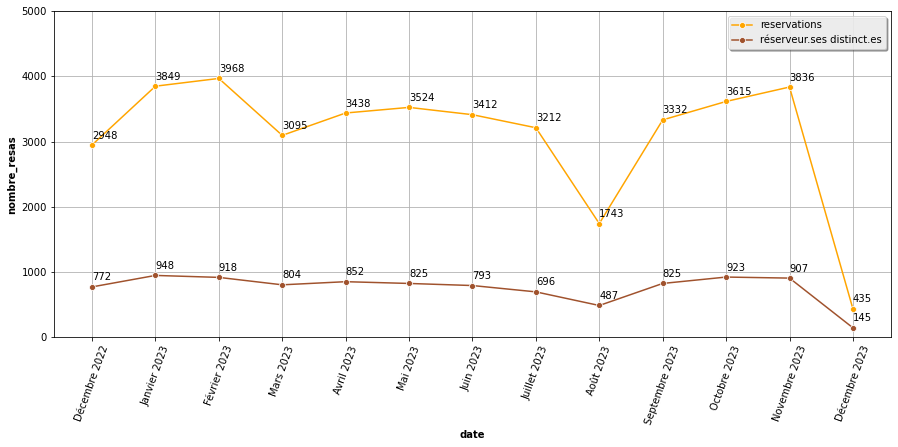

In [9]:
params = {'axes.titlesize': 15,
          'axes.titleweight':'bold',
          'axes.grid':'y',
          'axes.labelweight':'bold',
          'legend.shadow':True,
          'figure.subplot.hspace': 0.7,
          'figure.figsize':(15,6),          
         }

#plt.rcParams.update(params)

plt.xticks(rotation=70)

ax = sns.lineplot(data=resas_bymonth,
            x="date",
            y="nombre_resas",
            color="orange",
            label="reservations",
            marker="o"
           )

ax.set_ylim(0,5000)

for x, y in zip(resas_bymonth["date"], resas_bymonth["nombre_resas"]):
    plt.text(x = x, y = y+100,s = '{:.0f}'.format(y))

sns.lineplot(data=distinct_resas_bymonth,
             x="date",y="borrowernumber",
             color="sienna",
             label="réserveur.ses distinct.es",
             marker="o",
             ax=ax)

for x, y in zip(distinct_resas_bymonth["date"], distinct_resas_bymonth["borrowernumber"]):
    plt.text(x = x, y = y+100,s = '{:.0f}'.format(y))

In [10]:
resas_byage = pd.DataFrame(resas,columns=["age"])

In [11]:
resas_byage.loc[resas_byage["age"].str.match("NP"),["age"]] = -1

In [12]:
resas_byage["age"] = resas_byage.astype(int)

In [13]:
resas_byage.loc[resas_byage["age"].between(0,14),["age_lib_1"]] = '14 ans et moins'
resas_byage.loc[resas_byage["age"].between(15,24),["age_lib_1"]] = '15-24 ans'
resas_byage.loc[resas_byage["age"].between(25,64),["age_lib_1"]] = '25-64 ans'
resas_byage.loc[resas_byage["age"]>=65,["age_lib_1"]] = '65 ans et plus'
#resas_byage

In [14]:
resas_byage['age_lib_2'] = 0

In [15]:
resas_byage.loc[resas_byage['age'].between(0,2),['age_lib_2']]= '0-2 ans'
resas_byage.loc[resas_byage['age'].between(3,5),['age_lib_2']]= '3-5 ans'
resas_byage.loc[resas_byage['age'].between(6,10),['age_lib_2']]= '6-10 ans'
resas_byage.loc[resas_byage['age'].between(11,14),['age_lib_2']]= '11-14 ans'
resas_byage.loc[resas_byage['age'].between(15,17),['age_lib_2']]= '15-17 ans'
resas_byage.loc[resas_byage['age'].between(18,19),['age_lib_2']]= '18-19 ans'
resas_byage.loc[resas_byage['age'].between(20,24),['age_lib_2']]= '20-24 ans'
resas_byage.loc[resas_byage['age'].between(25,29),['age_lib_2']]= '25-29 ans'
resas_byage.loc[resas_byage['age'].between(30,39),['age_lib_2']]= '30-39 ans'
resas_byage.loc[resas_byage['age'].between(40,54),['age_lib_2']]= '40-54 ans'
resas_byage.loc[resas_byage['age'].between(55,64),['age_lib_2']]= '55-64 ans'
resas_byage.loc[resas_byage['age'].between(64,79),['age_lib_2']]= '65-79 ans'
resas_byage.loc[resas_byage['age']>=80,['age_lib_2']]= '80 ans et plus'

In [16]:
resas_byage['personne'] = 1

In [17]:
resas_pivot = pd.pivot_table(resas_byage,values='personne',
                             index=('age_lib_1','age_lib_2'),
                             aggfunc=sum
                            )

In [18]:
resas_concat = pd.concat([
    y.append(y.sum().rename((x, 'Sous-Total')))
    for x, y in resas_pivot.groupby(level=0)
]).append(resas_pivot.sum().rename(('Tous les âges','Total')))

# Nombre de réservations par âge ?

In [19]:
resas_concat

personne
age_lib_1       age_lib_2               
14 ans et moins 0-2 ans               68
                11-14 ans           4199
                3-5 ans              457
                6-10 ans            5211
                Sous-Total          9935
15-24 ans       15-17 ans           1906
                18-19 ans            468
                20-24 ans           1055
                Sous-Total          3429
25-64 ans       25-29 ans           1590
                30-39 ans           5004
                40-54 ans           9791
                55-64 ans           4902
                65-79 ans            540
                Sous-Total         21827
65 ans et plus  65-79 ans           4710
                80 ans et plus       397
                Sous-Total          5107
Tous les âges   Total              40298

# Réservations par type de cartes ?

In [20]:
#resas

In [21]:
resas_bycard = pd.DataFrame(resas,columns=['categorycode']).rename(columns={'categorycode':'type de carte'})
resas_bycard =resas_bycard.groupby('type de carte').size().reset_index().rename(columns={0:'nombre_reservations'})

In [22]:
#resas_bycard

In [23]:
resas_bycard.loc[resas_bycard['type de carte']=='BIBL',['lib_carte']] = 'Médiatheque simple'

In [24]:
#resas_bycard

In [25]:
resas_bycard.loc[(resas_bycard['type de carte']=='MEDA')
                 | (resas_bycard['type de carte']=='MEDB')
                 | (resas_bycard['type de carte']=='MEDC')
                 | (resas_bycard['type de carte']=='MEDP')
                 | (resas_bycard['type de carte']=='CSVT')
                 ,['lib_carte']] = 'Médiatheque Plus'

In [26]:
resas_bycard.loc[resas_bycard['type de carte']=='CSLT',['lib_carte']] = 'Consultation sur place'

In [27]:
#resas_bycard

In [28]:
resas_bycard.loc[resas_bycard['type de carte']=='BIBL',['type de carte']] = 'Médiathèque\n(gratuite)'
resas_bycard.loc[resas_bycard['type de carte']=='CLAS',['type de carte']] = 'Service Collectivités'
resas_bycard.loc[resas_bycard['type de carte']=='COLI',['type de carte']] = 'Prêt en nombre'
resas_bycard.loc[resas_bycard['type de carte']=='COLS',['type de carte']] = 'Collectivités\n(structures non scolaires)'
resas_bycard.loc[resas_bycard['type de carte']=='CSLT',['type de carte']] = 'Consultation\nsur place'
resas_bycard.loc[resas_bycard['type de carte']=='CSVT',['type de carte']] = 'Conservatoire'
resas_bycard.loc[resas_bycard['type de carte']=='CSVT',['type de carte']] = 'Collectivités\n(classes maternelles et primaires)'
resas_bycard.loc[resas_bycard['type de carte']=='MEDA',['type de carte']] = 'Médiathèque\n(5€)'
resas_bycard.loc[resas_bycard['type de carte']=='MEDB',['type de carte']] = 'Médiathèqe\n(17€)'
resas_bycard.loc[resas_bycard['type de carte']=='MEDC',['type de carte']] = 'Médiathèque\n(35€)'
resas_bycard.loc[resas_bycard['type de carte']=='MEDP',['type de carte']] = 'Personnel'

In [29]:
#resas_bycard

In [30]:
resas_bycard.loc[(resas_bycard['type de carte']=='CLAS')
                 | (resas_bycard['type de carte']=='COLI')
                 | (resas_bycard['type de carte']=='COLS')
                 ,['lib_carte']] = 'Autres'

In [31]:
resas_abonnement = resas_bycard.groupby(['lib_carte'])['nombre_reservations'].sum().reset_index()

In [32]:
resas_bycard = resas_bycard.groupby(['type de carte'])['nombre_reservations'].sum().reset_index()

#resas_bycard

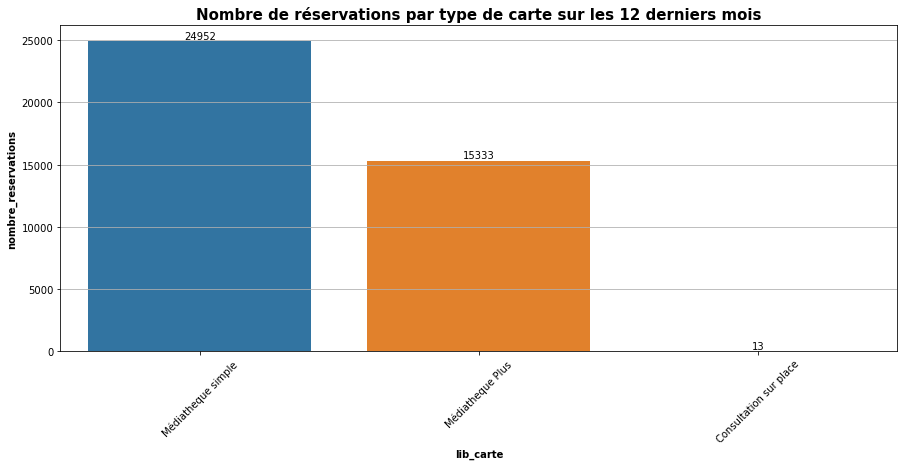

In [33]:
ax = sns.barplot(data=resas_abonnement.sort_values('nombre_reservations',ascending=False),x='lib_carte',y='nombre_reservations')
ax.set_title('Nombre de réservations par type de carte sur les 12 derniers mois')

ax.tick_params(axis='x',rotation=45)


for i in ax.containers:
    ax.bar_label(i,)

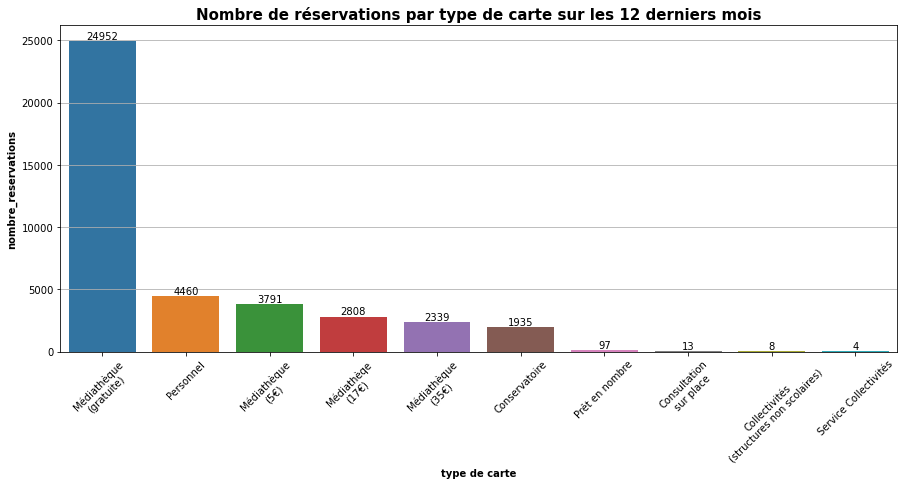

In [34]:
ax = sns.barplot(data=resas_bycard.sort_values('nombre_reservations',ascending=False),x='type de carte',y='nombre_reservations')
ax.set_title('Nombre de réservations par type de carte sur les 12 derniers mois')

ax.tick_params(axis='x',rotation=45)


for i in ax.containers:
    ax.bar_label(i,)